In [1]:
import subprocess
import os
import sys
import numpy as np
import pandas as pd
import random
import csv
import time

In [230]:
class midiFile(object):
    def __init__(self,fname):
        self.fname = fname
        self.oname = os.path.splitext(self.fname)[0] + "_NNCompose.mid"
        self.my_cols = ["instrument", "timing", "cmd","pitchshift","note","velocity","timeSig"]
        self.convertMidToCsv()
        self.df = self.convertCsvToDataframe()
        self.header = self.df[self.df['cmd'].str.contains("Header")]
        self.qn = int(self.header.iloc[0]['velocity'])
        self.tempo = int(self.df[self.df['cmd'].str.contains("Tempo")].iloc[0]['pitchshift'])
        self.command = self.df[self.df['instrument'] == 1]
        self.track2 = self.df[self.df['instrument'] == 2]
        self.startTrack = self.track2[self.track2['cmd'].str.contains("Start")]
        self.eof = self.df[self.df['cmd'].str.contains("End_of_file")]
        self.df = self.df[self.df['cmd'].str.contains("Note_on")]
        self.df['note'] = self.df['note'].apply(np.int64)

    def forceDataTypes(self,df):
        df['instrument'] = df['instrument'].astype(int)
        df['timing'] = df['timing'].astype(int)
        df['pitchshift'] = df['pitchshift'].astype(int)
        df['note'] = df['note'].astype(int)
        df['velocity'] = df['velocity'].astype(int)
        df['cmd'] = df['cmd'].astype(str)

    def convertMidToCsv(self):
        basename = os.path.splitext(self.fname)
        inp = "midiIn/" + str(basename[0]) + ".mid"
        if not os.path.isfile(inp):
            print("Did not find .mid file, trying .midi!")
            inp = "midiIn/" + str(basename[0]) + ".midi"
            if not os.path.isfile(inp):
                raise ValueError("No MIDI File Found")
        out = "csv/" + str(basename[0]) + ".csv"
        cmd = "midicsv " + inp + " >! " + out 
        csvCreated = subprocess.Popen(cmd, shell=True)
        print("Converting to CSV")
        time.sleep(5)

    def convertCsvToDataframe(self):
        basename = os.path.splitext(self.fname)
        inp = "csv/" + str(basename[0]) + ".csv"
        return pd.read_csv(inp, names=self.my_cols)

    def convertNotesToName(self):
        notename = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        #self.df['noteName'] = self.df['note'].apply(lambda x: int(x % 12))
        self.df['noteName'] = self.df['note'] #if trying to include octaves)

    def convertMidiToMp3(self):
        basename = os.path.splitext(self.oname)
        inname = "midiOut/" + str(basename[0]) + ".mid"
        outname = "mp3Out/" + str(basename[0]) + ".mp3"
        cmd = "timidity -Ow -o - " + inname + "| lame - " + outname
        mp3Created = subprocess.Popen(cmd, shell=True)
        time.sleep(5)
        print("Created ", outname)
        
    def get_trainable_arrays(self, seq_length=10):
        data = self.df['note'].values
        x = []
        y = []
        for i in range(seq_length,len(data)):
            x.append(data[i-seq_length:i])
            y.append(data[i])
        print("X & Y Correlation:\n",x[0],y[0],"\nActual Data Correlation:\n",data[seq_length-2:seq_length+1])
        X = np.reshape(x, (len(x), seq_length, 1))
        Y = np.reshape(y, len(y))
        return X,Y
        
    def encode_target(self, y):
        n_values = 128
        ohe = np.eye(n_values)[y]
        return ohe
    
    def convert_to_midi_format(self, result_notes):
        notes = []
        currentTime = 0

        for ind in result_notes:
            notes.append([2,currentTime, "Note_on_c", 2, int(ind), 95,False])
            beatLength = 3
            while beatLength in [3,5,6,7]:
                beatLength = random.randint(1,8)
            dt = int(self.qn/beatLength)
            currentTime = currentTime+dt
            notes.append([2,currentTime, "Note_off_c", 2, int(ind), 95, False])

        notes.append([2, currentTime, "End_track"])
        return notes
    
    def check_valid_entry(self, item):
        if type(item) == str:
            return True
        elif not np.isnan(item):
            return True
        else:
            return False    

    def makeMidiOut(self,notes):
        basename = os.path.splitext(self.oname)
        filename = "csv/"+str(basename[0])+".csv"
        file_order = [self.header,self.command,self.startTrack,notes]
        with open(filename, 'w') as f:
            for section in file_order:
                if not type(section) == list:
                    try:
                        l = section.values.tolist()
                    except AttributeError:
                        l = section.tolist()
                else:
                    l = section
                for item in l:
                    outstr = ""
                    
                    if len(item) == 3:
                        if self.check_valid_entry(item[0]):
                            outstr = outstr + str(int(item[0])) + ", "
                        if self.check_valid_entry(item[1]):
                            outstr = outstr + str(int(item[1])) + ", " 
                        if self.check_valid_entry(item[2]):
                            outstr = outstr + str(item[2].lstrip(' ')) + ", "
                    else:
                        if self.check_valid_entry(item[0]):
                            outstr = outstr + str(int(item[0])) + ", "
                        if self.check_valid_entry(item[1]):
                            outstr = outstr + str(int(item[1])) + ", " 
                        if self.check_valid_entry(item[2]):
                            outstr = outstr + str(item[2].lstrip(' ')) + ", "
                        if self.check_valid_entry(item[3]):
                            if type(item[3]) == str:
                                outstr = outstr + str(item[3]) + ", "
                            else:
                                outstr = outstr + str(int(item[3])) + ", "
                        if self.check_valid_entry(item[4]):
                            outstr = outstr + str(int(item[4])) + ", "
                        if self.check_valid_entry(item[5]):
                            outstr = outstr + str(int(item[5])) + ", "
                        if self.check_valid_entry(item[6]):
                            outstr = outstr + str(int(item[6])) + ", "
                    outstr = outstr.rstrip(', ') + "\n"
                    f.write(outstr)
            item = self.eof.iloc[0].values
            if self.check_valid_entry(item[0]):
                outstr = outstr + str(int(item[0])) + ", "
            if self.check_valid_entry(item[1]):
                outstr = outstr + str(int(item[1])) + ", " 
            if self.check_valid_entry(item[2]):
                outstr = outstr + str(item[2].lstrip(' ')) + ", "
            outstr = outstr.rstrip(', ') + "\n"
            f.write(outstr)
        self.csv_to_midi()
    
    def csv_to_midi(self):
        basename = os.path.splitext(self.oname)
        filename = "csv/"+str(basename[0])+".csv"
        out = "midiOut/" + str(basename[0]) + ".mid"
        cmd = "csvmidi " + filename + " " + out 
        midCreated = subprocess.Popen(cmd, shell=True)
        print("Converting to MIDI")
        time.sleep(5)

In [140]:
# Create first network with Keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
#sciKit for pipeline and CV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class network(object):
    def __init__(self, X):
        self.model = self.getModel(X)

    def getModel(self,X):
        # create model
        model = Sequential()
        model.add(LSTM(400, input_shape=(X.shape[1],X.shape[2]), return_sequences=True))
        model.add(LSTM(200, input_shape=(X.shape[1],X.shape[2])))
        model.add(Dense(128,activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model
    
    def train(self,x,y,epochs=20,batch_size=5,filepath="recent_lstm_model_weights.h5"):
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        # fit the model
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
        self.model = self.load_best_model(filepath)
        return self.model
        
    def load_best_model(self, filepath="recent_lstm_model_weights.h5"):
        return load_model(filepath)

In [231]:
mf = midiFile("Bach_Cantate_BWV8.midi")
sl = 20
X,Y = mf.get_trainable_arrays(seq_length=sl)
data_seed = X[0]
data_seed = np.reshape(data_seed, (1, sl, 1))

Did not find .mid file, trying .midi!
Converting to CSV
X & Y Correlation:
 [43 62 62 67 62 55 47 64 55 48 62 47 55 60 45 43 62 60 59 43] 57 
Actual Data Correlation:
 [59 43 57]


In [141]:
target = mf.encode_target(Y)
model = network(X)
model.train(X,target,epochs=50,batch_size=5)

Epoch 1/50
168/168 [==============================] - 8s - loss: 3.5397     
Epoch 2/50
168/168 [==============================] - 5s - loss: 2.9112     
Epoch 3/50
168/168 [==============================] - 5s - loss: 2.8500     
Epoch 4/50
168/168 [==============================] - 5s - loss: 2.8113     
Epoch 5/50
168/168 [==============================] - 5s - loss: 2.7864     
Epoch 6/50
168/168 [==============================] - 5s - loss: 2.8040     
Epoch 7/50
168/168 [==============================] - 5s - loss: 2.8066     
Epoch 8/50
168/168 [==============================] - 5s - loss: 2.7634     
Epoch 9/50
168/168 [==============================] - 5s - loss: 2.7839     
Epoch 10/50
168/168 [==============================] - 5s - loss: 2.7863     
Epoch 11/50
168/168 [==============================] - 6s - loss: 2.7593     
Epoch 12/50
168/168 [==============================] - 5s - loss: 2.7465     
Epoch 13/50
168/168 [==============================] - 5s - loss: 2.7386 

In [234]:
results = []
for i in range(4000):
    if i%500==0:
        print("Generating point ",i)
    data_seed = np.reshape(data_seed, (1, sl, 1))
    next_val = model.model.predict(data_seed)
    next_val = np.argmax(next_val)
    results.append(next_val)
    next_val = np.reshape(next_val,(1))
    data_seed = data_seed[0].tolist()
    data_seed.append([next_val])
    data_seed = data_seed[1:len(data_seed)]

Generating point  0
Generating point  500
Generating point  1000
Generating point  1500
Generating point  2000
Generating point  2500
Generating point  3000
Generating point  3500


In [142]:
train_results = model.model.predict(X)
tr_results = []
for val in train_results:
    tr_results.append(np.argmax(val))

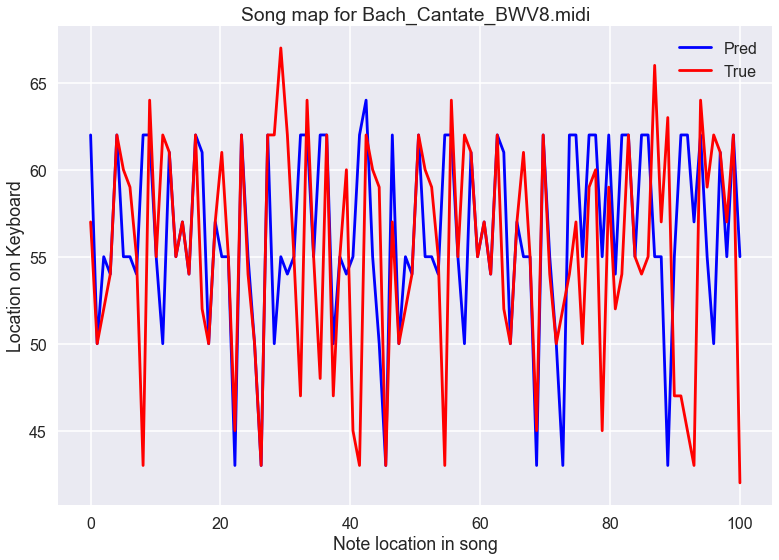

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn-poster")
lowx = 0
highx = 100
plt.plot(np.linspace(0,len(tr_results[lowx:highx]),len(tr_results[lowx:highx])),tr_results[lowx:highx],'b',label="Pred")
plt.plot(np.linspace(0,len(Y[lowx:highx]),len(Y[lowx:highx])),Y[lowx:highx],'r',label="True");
plt.xlabel("Note location in song")
plt.ylabel("Location on Keyboard")
plt.title("Song map for %s"%mf.fname)
plt.legend()

In [232]:
notes = mf.convert_to_midi_format(tr_results)
mf.makeMidiOut(notes)

Converting to MIDI


In [233]:
mf.convertMidiToMp3()

Created  mp3Out/Bach_Cantate_BWV8_NNCompose.mp3


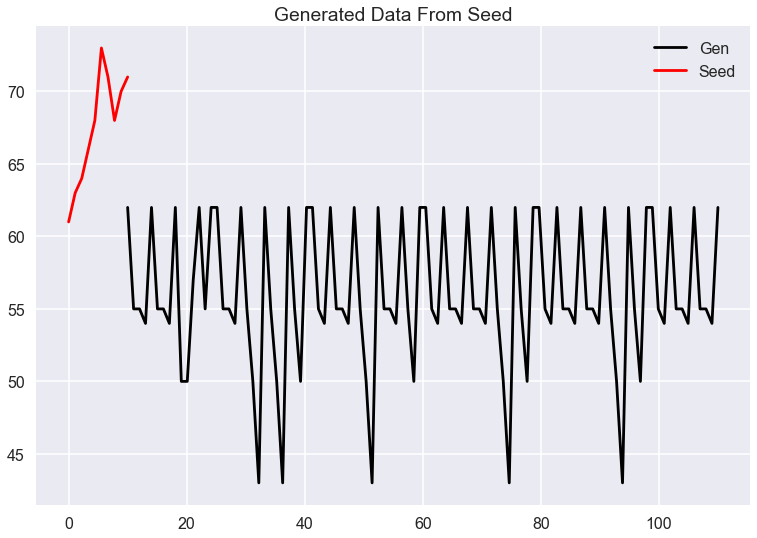

In [235]:
lowx = 0
highx = 100
plt.plot(np.linspace(0,len(results[lowx:highx]),len(results[lowx:highx]))+seq_length,results[lowx:highx],'k',label="Gen")
plt.plot(np.linspace(0,len(data[0:seq_length]),len(data[0:seq_length])),data[0:seq_length],'r',label="Seed");
plt.title("Generated Data From Seed")
plt.legend()